---
title: Finite Difference
suptitle: Loops, Slicing, and Stencils
short_title: Finite Difference
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [187]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [188]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
# defime some variables
tmax = 10.0
nt = 1_000
a = 1
dt = tmax / nt
t0 = tmax / 2
time = np.linspace(0, tmax, nt)

def fn(time, t0, a):
    return (1 / np.sqrt(2 * np.pi * a)) * np.exp(- (((time - t0)**2) / (2 * a)))

def dfn(time, t0, a):
    return (-(time - t0)/a) * (1/np.sqrt(2*np.pi*a))*np.exp(-(time-t0)**2/(2*a))


In [190]:
f = fn(time, t0, a)
df = dfn(time, t0, a)

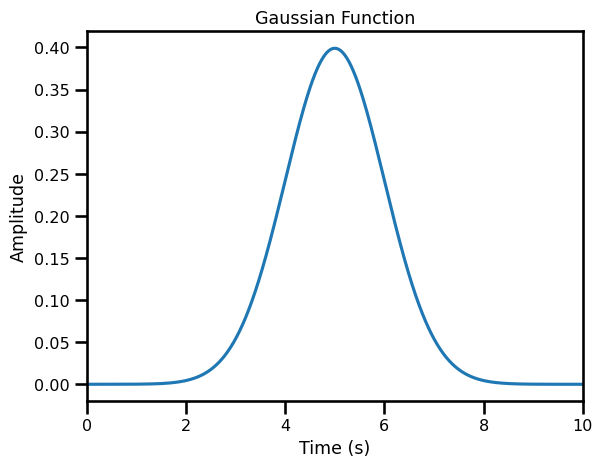

In [191]:
fig, ax = plt.subplots()
ax.plot(time, f)
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.show()

In [192]:
from jaxtyping import Array, Float

### RHS

So let's rewrite the PDE only looking at the spatial discretization.

```{math}
:label: discretization_spatial
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right) 
```

Notice that the spatial derivatives are *universal* in the sense that these operations are agnostic to the scalar field. So these can easily be made into simple functions.

```{math}
:label: forward_diff
\begin{aligned}
\text{bd}_x &:= \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right) 
\end{aligned}
```

In [193]:
def diff_back_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i+1] - u[i])/dx
    return un

def diff_forward_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i] - u[i-1])/dx
    return un

def diff_central_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i+1] - u[i-1])/(2*dx)
    return un

def diff_back_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="constant")
    return (u[1:] - u[:-1]) / dx

def diff_forward_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="constant")
    return (u[1:] - u[:-1]) / dx

def diff_central_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="constant")
    return (u[2:] - u[:-2]) / ( 2 * dx )

In [194]:
np.diff(f, n=1).shape, f.shape

((999,), (1000,))

In [195]:
derivatives = dict()
f = fn(time, t0, a)
derivatives["backward_loop"] = diff_back_1d_loop(f, dx=dt)
derivatives["forward_loop"] = diff_forward_1d_loop(f, dx=dt)
derivatives["central_loop"] = diff_central_1d_loop(f, dx=dt)

derivatives["backward_slice"] = diff_back_1d(f, dx=dt)
derivatives["forward_slice"] = diff_forward_1d(f, dx=dt)
derivatives["central_slice"] = diff_central_1d(f, dx=dt)
# serket 

np.testing.assert_array_almost_equal(derivatives["backward_loop"][1:-1], derivatives["backward_slice"][1:-1], decimal=5)
np.testing.assert_array_almost_equal(derivatives["forward_loop"][1:-1], derivatives["forward_slice"][1:-1], decimal=5)
np.testing.assert_array_almost_equal(derivatives["central_loop"][1:-1], derivatives["central_slice"][1:-1], decimal=5)

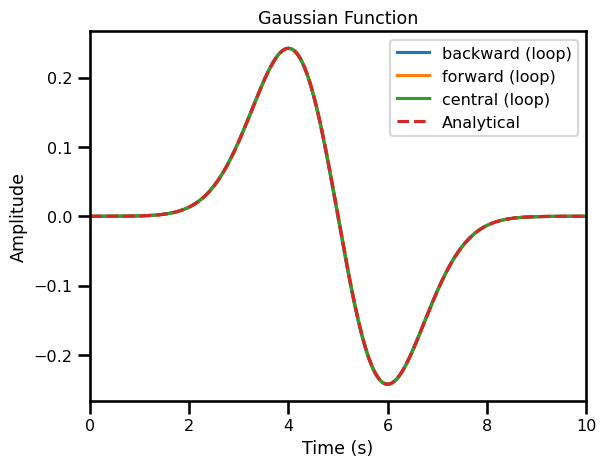

In [196]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["backward_loop"], label="backward (loop)")
ax.plot(time, derivatives["forward_loop"], label="forward (loop)")
ax.plot(time, derivatives["central_loop"], label="central (loop)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

## Finite Difference Coefficients

In [197]:
import serket as sk

derivatives["serket"] = sk.fd.difference(f, axis=0, accuracy=2, step_size=dt)
np.testing.assert_array_almost_equal(derivatives["serket"][1:-1], derivatives["central_slice"][1:-1], decimal=3)

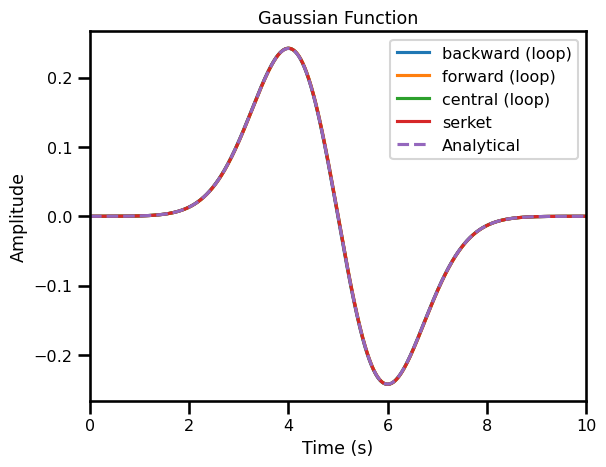

In [198]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["backward_loop"], label="backward (loop)")
ax.plot(time, derivatives["forward_loop"], label="forward (loop)")
ax.plot(time, derivatives["central_loop"], label="central (loop)")
ax.plot(time, derivatives["serket"], label="serket")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

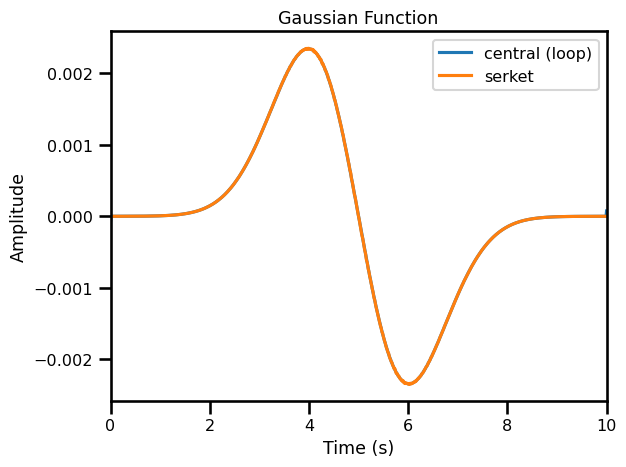

In [199]:
fig, ax = plt.subplots()
ax.plot(time, 
        10*(derivatives["central_loop"] - df), label="central (loop)")
ax.plot(time, 
        10*(derivatives["serket"] - df), label="serket")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

So let's rewrite the PDE only looking at the spatial discretization.

```{math}
:label: discretization_spatial
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right) 
```


In [219]:
import kernex as kex

    
@kex.kmap(kernel_size=(3,), padding="same", relative=True)
def fd_central_kernel(u, dx):
    return (u[1] - u[-1]) / (2 * dx)
    

def fd_central_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = jnp.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un = un.at[i].set((u[i+1] - u[i-1])/(2*dx))
    return un

def fd_central_slice(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="constant")
    return (u[2:] - u[:-2]) / ( 2 * dx )

In [230]:
%timeit fd_central_kernel(f, dt).block_until_ready()
%timeit fd_central_loop(f, dt).block_until_ready()
%timeit fd_central_slice(f, dt).block_until_ready()
%timeit sk.fd.difference(f, axis=0, accuracy=2, step_size=dt).block_until_ready()

2.81 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
363 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.98 µs ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [231]:
from functools import partial
fn = jax.jit(fd_central_kernel, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_loop, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_slice, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = partial(sk.fd.difference, axis=0, accuracy=2, step_size=dt)
fn = jax.jit(fn, static_argnums=(1,2,3,))
%timeit fn(f).block_until_ready()

4.07 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.67 µs ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.66 µs ± 64.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.98 µs ± 4.32 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
derivatives = dict()

derivatives["kernel"] = fd_central_kernel(f, dt)
derivatives["loop"] = fd_central_loop(f, dt)
derivatives["slice"] = fd_central_slice(f, dt)
derivatives["serket"] = sk.fd.difference(f, axis=0, accuracy=2, step_size=dt)

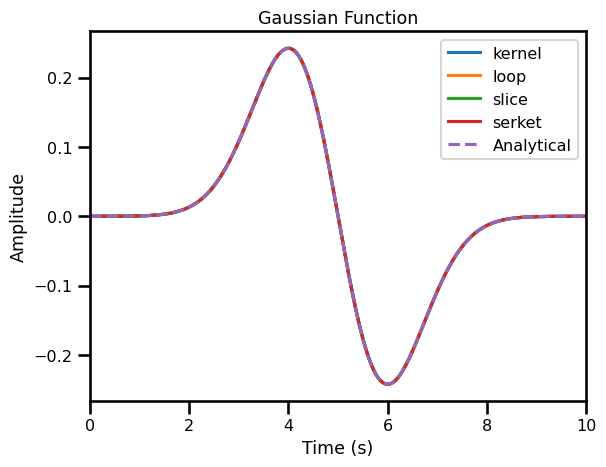

In [211]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["kernel"], label="kernel")
ax.plot(time, derivatives["loop"], label="loop")
ax.plot(time, derivatives["slice"], label="slice")
ax.plot(time, derivatives["serket"], label="serket")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

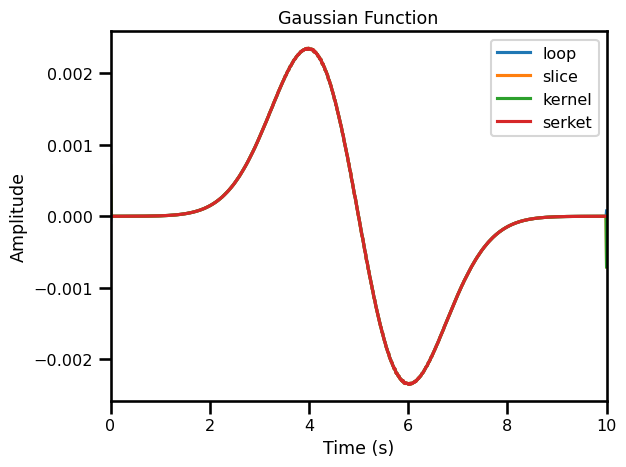

In [214]:
fig, ax = plt.subplots()
ax.plot(time, 
        10*(derivatives["loop"] - df), label="loop")
ax.plot(time, 
        10*(derivatives["slice"] - df), label="slice")
ax.plot(time, 
        10*(derivatives["kernel"] - df), label="kernel")
ax.plot(time, 
        10*(derivatives["serket"] - df), label="serket")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()